# ABC Rejection Sampling
The ABC Rejection Sampling Algorithm is the most basic scheme for Approximate Bayesian Computation (ABC). ABC is used to perform Bayesian Inference (more specifically: obtain samples from a posterior distribution), when a likelihood function is not known. Here, we will show how ABC Rejection Sampling works for a simple example where we know the likelihood in order to compare the closed-form solution to the ABC posterior samples

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_utils import plot_mvnormal

## Closed-form posterior
For a 2-dimensional Gaussian prior with mean $\mu_0$ and covariance $\Sigma_0$ and data with mean $\bar{x}$ and covariance $\Sigma$ (generated by sampling from a 2-dimensional Gaussian, whose variance we assume to be known), the posterior parameters can be derived in closed form:

$$ \Sigma_N = (\Sigma_0^{-1} + N \Sigma^{-1})^{-1}$$
$$ \mu_N = \Sigma_N (N \Sigma^{-1} \bar{x} + \Sigma_0^{-1} \mu_0) $$

In [2]:
# compute the posterior parameters for Gaussian likelihood with conjugate prior
def gauss_posterior(mu0, sigma0, data):
    # sample statistics
    N = data.shape[0]
    cov = np.cov(data.T)
    mean = np.mean(data, axis=0)
    
    # posterior parameters with conjugate prior
    sigmaN = np.linalg.inv(np.linalg.inv(sigma0) + N * np.linalg.inv(cov))
    muN = sigmaN @ (N * np.linalg.inv(cov) @ mean + np.linalg.inv(sigma0) @ mu0)
    return muN, sigmaN

## Example data
We choose some prior parameters and generate some data. 

In [3]:
# prior parameters
mu0 = np.array([4.0, 4.0])
sigma0 = np.array([[1,-0.5],[-0.5,0.7]])

# data parameters
mu = np.array([5.0, 7.0])
sigma = np.array([[2,0.5],[0.5,1]])
N = 10

# generate some data
x = np.random.multivariate_normal(mu, sigma, N)

We visualize the prior, the data and the closed-form posterior

<IPython.core.display.Javascript object>


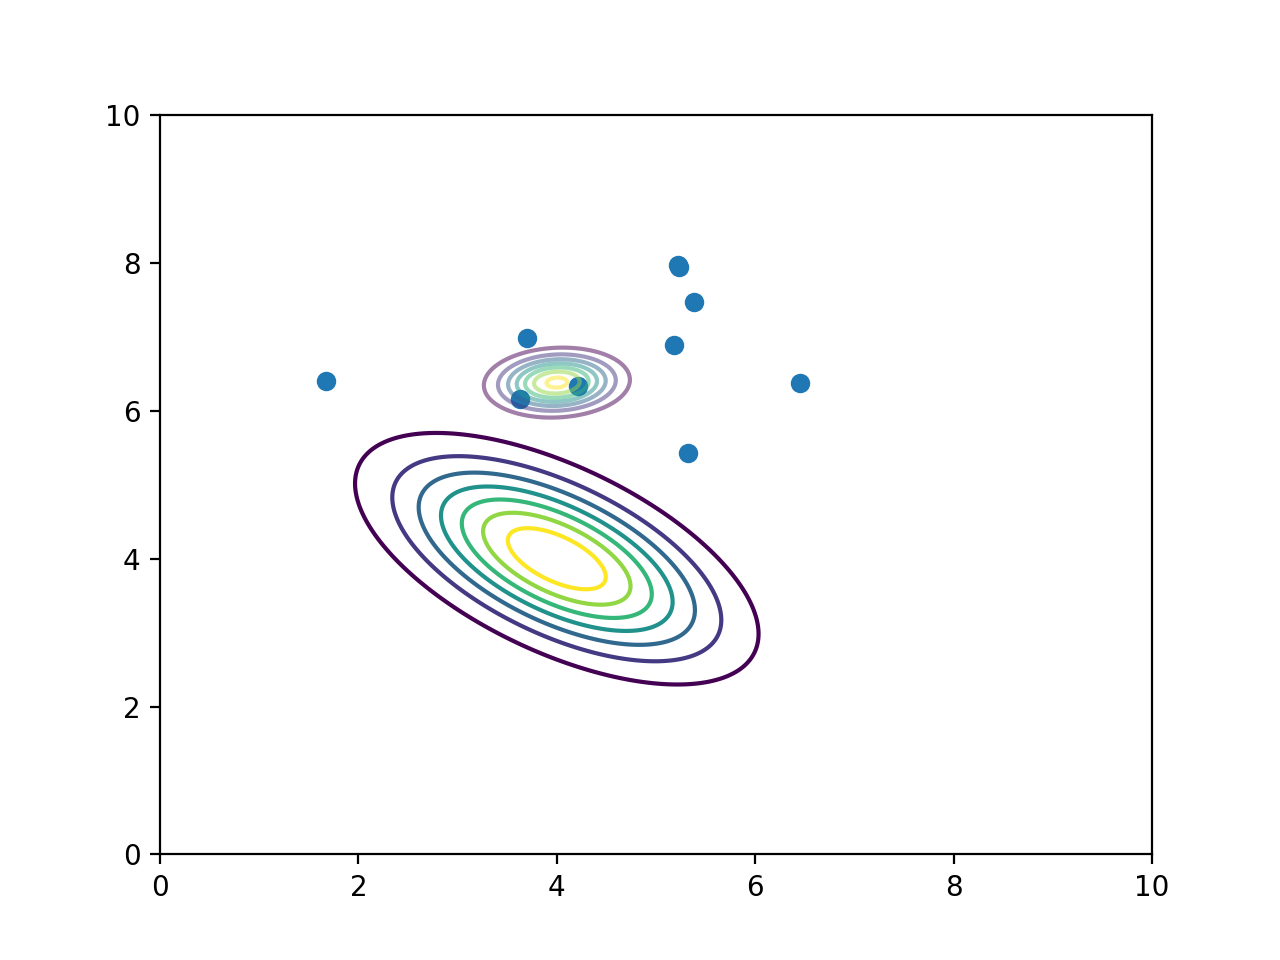

(<matplotlib.figure.Figure at 0x108b41748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10bebb208>)

In [4]:
# plot the prior
f, ax = plot_mvnormal(mu0, sigma0)

# plot the data
ax.scatter(x[:,0], x[:,1])

# get the analytical posterior parameters
muN, sigmaN = gauss_posterior(mu0, sigma0, x)

# plot the analytical posterior
plot_mvnormal(muN, sigmaN, ax=ax, alpha=0.5)

## ABC Rejection sampling
We now want to compare the closed-form posterior with posterior samples obtained with ABC.
In order to perform ABC, we use the simple rejection sampling algorith (for a good description see Sunnåker et al., 2013).

1. Sample a set of n parameter values from the prior. In this case, the parameter is of the i-th $\mu_i$.
2. Generate a set of data for each of the parameter points. Compute its sufficient statistics $\omega_i$ (in this case $\bar{x}$ and $\Sigma$).
3. Using a distance measure $\rho(\omega_i, \omega_E)$ between sufficient statistics (in this example the Bhattacharyya distance), compare the observed data to the similated data. If the distance is smaller than some threshold $\epsilon$, we accept this sample.
4. The posterior is approximated using the parameter values of the accepted samples.

In [5]:
# distance measure between sufficient statistics of two data sets
def bhatt(x, y):
    # compute sufficient statistics (mean and covariance)
    sigma1 = np.cov(x.T)
    mu1 = np.mean(x, axis=0)
    
    sigma2 = np.cov(y.T)
    mu2 = np.mean(y, axis=0)
    
    
    det = np.linalg.det
    sigma = 0.5 * (sigma1 + sigma2)
    da = 0.125 * (mu1 - mu2).T @ np.linalg.inv(sigma) @ (mu1 - mu2)
    db = 0.5 * np.log(det(sigma) / np.sqrt(det(sigma1) * det(sigma2)))
    return da + db

<IPython.core.display.Javascript object>


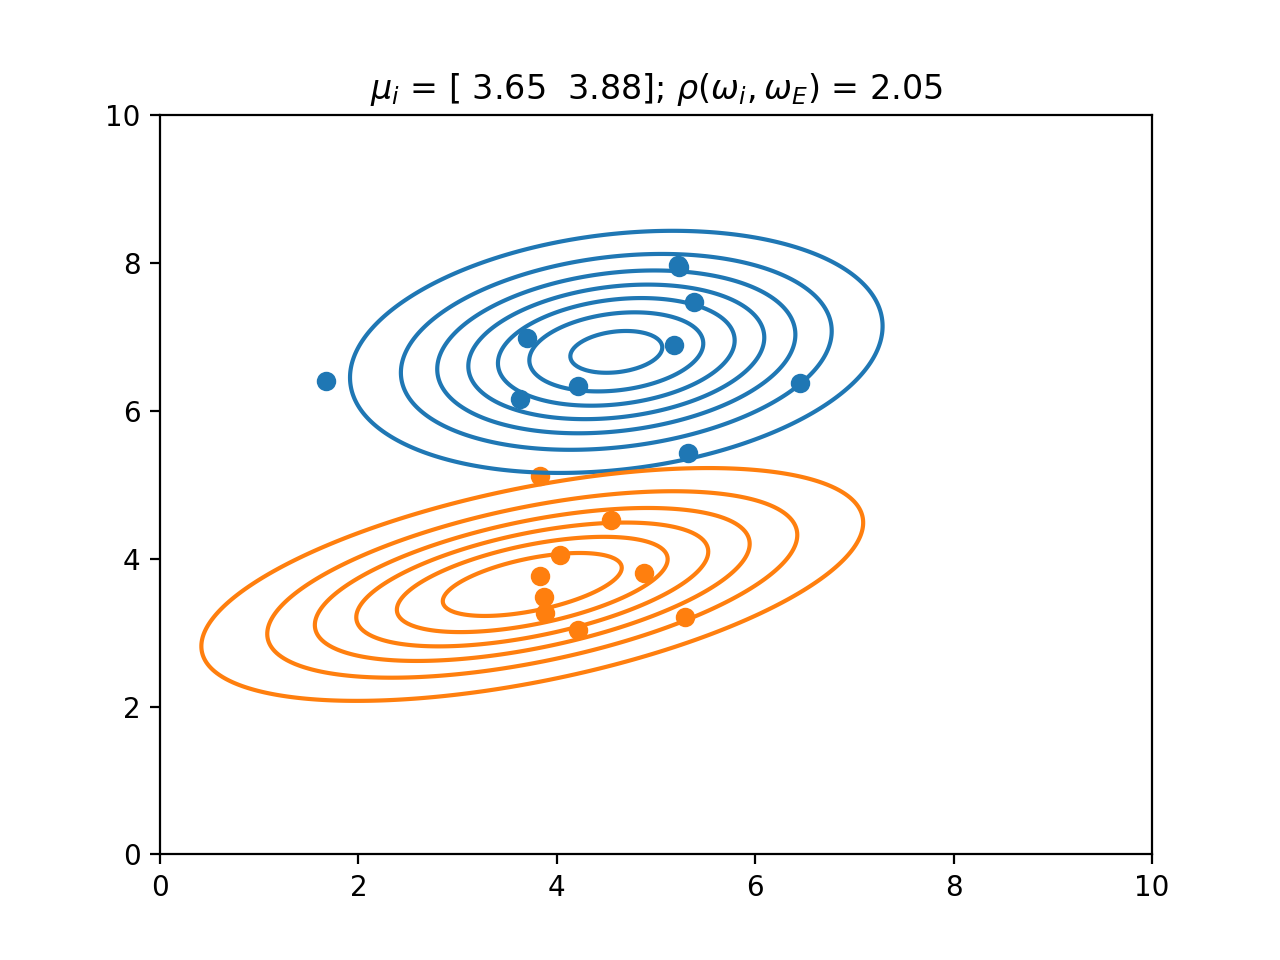

In [6]:
def sample_data(mu0, sigma0, sigma):
    # sample from the prior distribution
    mu_sim = np.random.multivariate_normal(mu0, sigma0)

    # simulate data using the sampled parameters
    data_sim = np.random.multivariate_normal(mu_sim, sigma, 10)

    return mu_sim, data_sim

mu_sim, data_sim = sample_data(mu0, sigma0, sigma)
dist = bhatt(x, data_sim)

f, ax = plt.subplots()
ax.scatter(x[:,0], x[:,1], color='C0')
plot_mvnormal(x.mean(axis=0), np.cov(x.T), ax=ax, colors='C0')
ax.scatter(data_sim[:,0], data_sim[:,1], color='C1')
plot_mvnormal(data_sim.mean(axis=0), np.cov(data_sim.T), ax=ax, colors='C1')
ax.set_title(r'$\mu_i$ = {}; $\rho(\omega_i, \omega_E)$ = {}'.format(np.round(mu_sim, 2), round(dist,2)))

In [7]:
# rejection sampling procedure
def rejection_sampling(mu0, sigma0, sigma, data, n_samples, eps):
    # initialize empty array for posterior samples
    mu_post = np.empty((0,2), float)
    
    # until we reach the desired amount of samples
    while mu_post.shape[0] < n_samples:
        
        # simulate data using the sampled parameters
        mu_sim, data_sim = sample_data(mu0, sigma0, sigma)


        # if their distance is smaller than the threshold
        if bhatt(data, data_sim) < eps:
            # keep the sample
            mu_post = np.append(mu_post, [mu_sim], axis=0)
    
    return mu_post

# obtain samples from the posterior
posterior = rejection_sampling(mu0, sigma0, sigma, x, 20, eps=0.1)

<IPython.core.display.Javascript object>


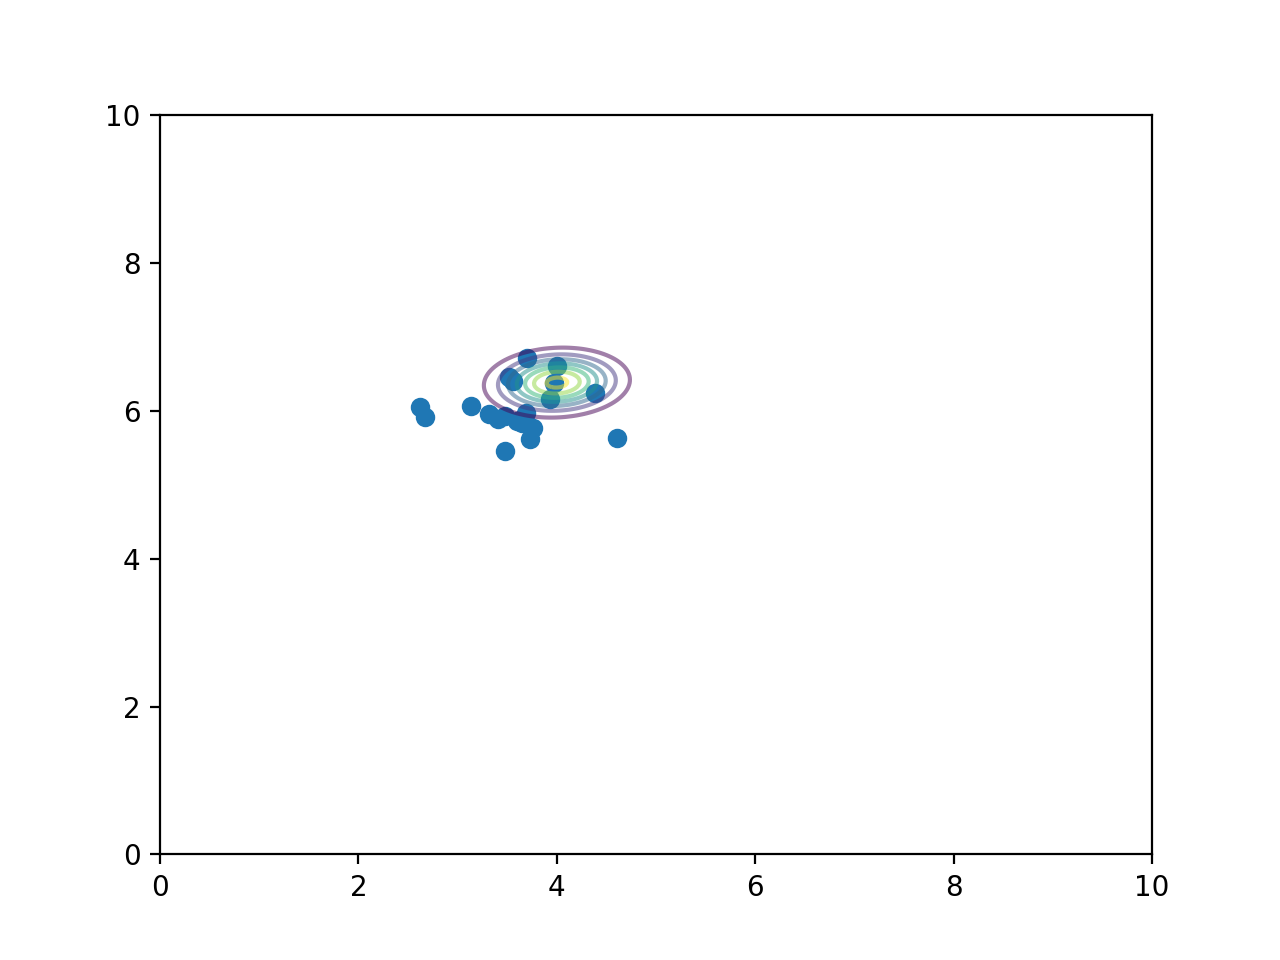

In [8]:
# plot analytical posterior
f, ax = plot_mvnormal(muN, sigmaN, alpha=0.5)

# plot approximated posterior
plt.scatter(posterior[:,0], posterior[:,1])
plt.show()